### Lets see how to create a dataset for Sentiment Analysis by scraping user reviews for Android apps. We will convert the app and review information into Data Frames and save that to CSV files.

### We will learn how to:
#### * Set a goal and inclusion criteria for your dataset
#### * Get real-world user reviews by scraping Google Play
#### * Use Pandas to convert and save the dataset into CSV files

#### Let's install the required packages and setup the imports:

In [1]:
!pip install google-play-scraper


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#### We want to get the necessary feedback for different applications, both negative and positive reviews would be good but the negative one can reveal critical features that are missing in an application's service. Lucky for us, Google Play as plenty of applications, reviews and scores. We will be scraping application info and reviews using the google-play-scraper package. 

#### There are a lot of applications which we can choose to analyze, but the different application categories contain different audiences and domain specific knowledge. We will start simple. We want apps that have been around some time, so opinion is collected organically. We want to mitigate advertising strategies as much as possible. Apps are constantly being updated, so the time of the review is an important factor. Ideally, you would want to collect every possible review and work with that. However, in the real world, data is often limited. So, we'll do the best we can.

#### Let's choose some apps that fit the criteria from the Productivity category. We'll use AppAnnie to select some of the top US apps:

In [24]:
app_packages = [
    'com.styleseat.promobile', 'com.shortcutssoftware.mysalon.hair',
    'com.loreal.swatchbook', 'com.taper.cp'
]

len(app_packages)

4

## Scraping App Information
### Lets scrape information for each app

In [25]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|██████████| 4/4 [00:11<00:00,  2.92s/it]


### We got the info for all 4 apps. Let's write a helper function that prints JSON objects a bit better:

In [26]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

### Here is a sample app information from the list:

In [27]:
print_json(app_infos[0])

{
  "adSupported": false,
  "appId": "com.styleseat.promobile",
  "categories": [
    {
      "id": "PRODUCTIVITY",
      "name": "Productivity"
    }
  ],
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "StyleSeat is a beauty and grooming marketplace that helps millions of new clients search, discover, and book beauty and barber professionals. It\u2019s the only booking platform that grows your revenue for you by helping you get exposure to new clients and earn more for appointments. \r\n\r\nFOR PROFESSIONALS: \r\n\r\nMost professionals double their revenue in the first year with our unique growth features: \r\n\r\n- Get promoted and get exposure to new clients through StyleSeat\u2019s marketing program \r\n- When you have last minute cancellations, StyleSeat will reach out to clients and help you fill them\r\n- Get paid more for your most popular time slots\r\n- Get paid when clients no-show or cancel la

### This contains lots of information including the number of ratings, number of reviews and number of ratings for each score (1 to 5). Let's ignore all of that and have a look at their beautiful icons:

C:\Users\oyeni\AppData\Local\Temp\ipykernel_25784\606549505.py:11: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  img = plt.imread(ai['icon'])


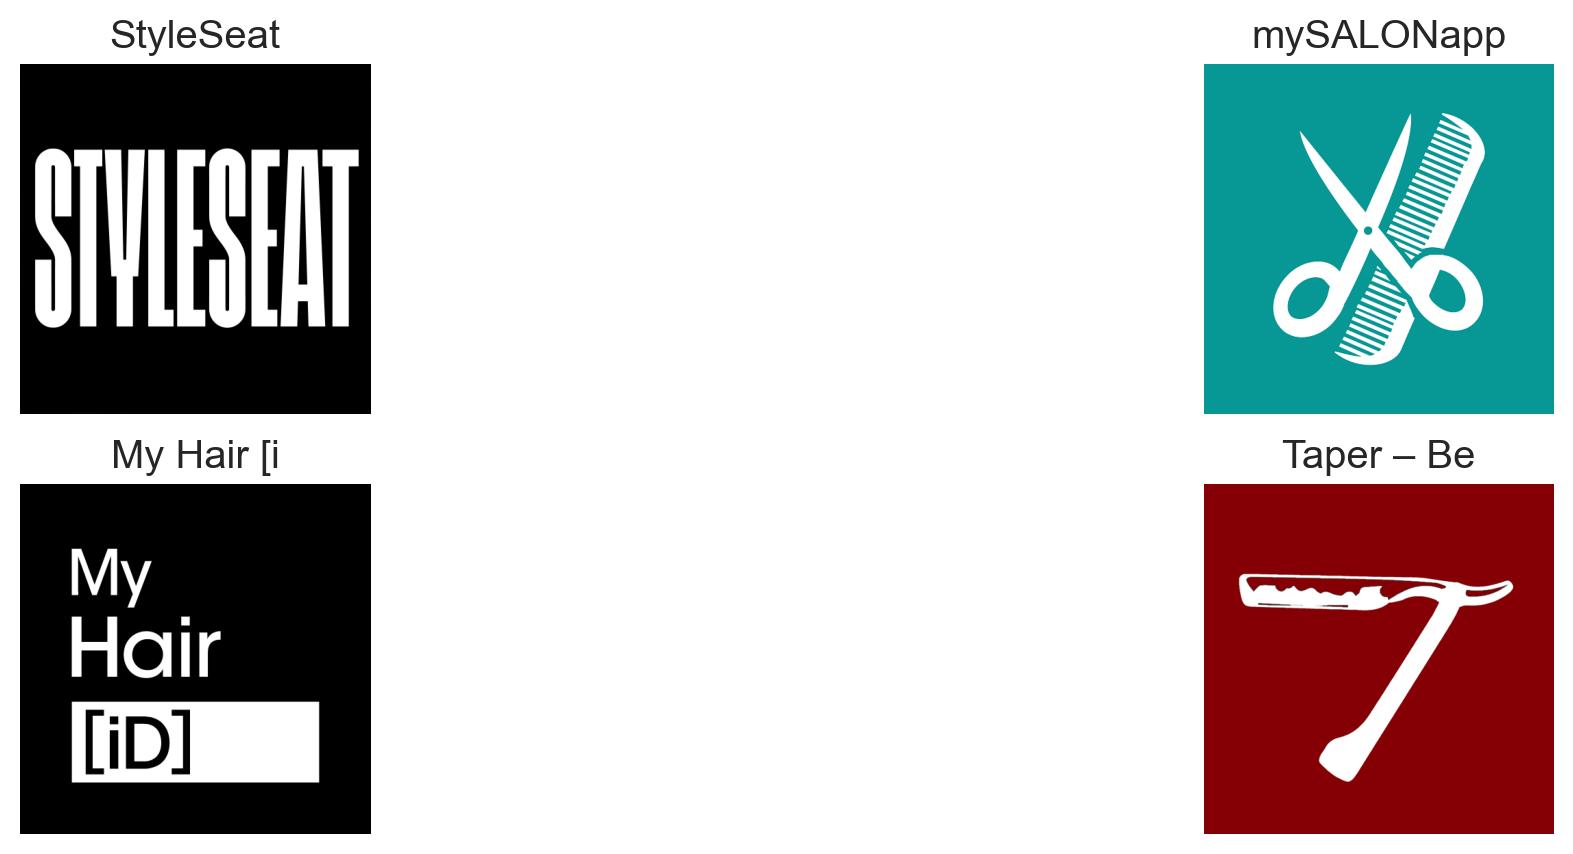

In [28]:
def format_title(title):
  sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
  if sep_index != -1:
    title = title[:sep_index]
  return title[:10]

fig, axs = plt.subplots(2, len(app_infos) // 2, figsize=(14, 5))

for i, ax in enumerate(axs.flat):
  ai = app_infos[i]
  img = plt.imread(ai['icon'])
  ax.imshow(img)
  ax.set_title(format_title(ai['title']))
  ax.axis('off')

### We will store the app information for later by converting the JSON objects into a Pandas dataframe and saving the result into a CSV file:

In [29]:
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.to_csv('apps.csv', index=None, header=True)

## Scraping App Reviews
### In an ideal world, we would get all the reviews. But there are lots of them and we're scraping the data. That wouldn't be very polite. What should we do?

### We want:

#### * Balanced dataset - roughly the same number of reviews for each score (1-5)
#### * A representative sample of the reviews for each app

### We can satisfy the first requirement by using the scraping package option to filter the review score. For the second, we'll sort the reviews by their helpfulness, which are the reviews that Google Play thinks are most important. Just in case, we'll get a subset from the newest, too:

In [32]:
app_reviews = []

for ap in tqdm(app_packages):
  for score in list(range(1, 6)):
    for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
      rvs, _ = reviews(
        ap,
        lang='en',
        country='us',
        sort=sort_order,
        count= 200 if score == 3 else 100,
        filter_score_with=score
      )
      for r in rvs:
        r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
        r['appId'] = ap
      app_reviews.extend(rvs)

100%|██████████| 4/4 [00:28<00:00,  7.05s/it]


### Note that we're adding the app id and sort order to each review. Here's an example for one:

In [33]:
print_json(app_reviews[0])

{
  "appId": "com.styleseat.promobile",
  "appVersion": null,
  "at": "2023-04-08 21:22:16",
  "content": "Styleseat is a difficult app to use. It is pointless to install. Your favorites are listed on top of the page, and you have to swipe for hours to look for what you want. When you swipe, the app clicks on a page you did not intend to do. Hidden fees are all over this app. For the messaging feature, you are not able to review the business of the owner, and you have to put their name in the search bar. That option doesn't work, and it says there are no search results for the owner you've messaged.",
  "repliedAt": "2023-04-08 23:01:46",
  "replyContent": "Hi Ana! So sorry for the recent experience you've had using our platform. We update our app weekly so please be sure your app is up to date! We appreciate your feedback. Please reach out to us here: https://styleseat.freshdesk.com/support/home so that we can go over any features and other questions you may have.",
  "reviewCreatedVe

### Number of reviews 

In [34]:
len(app_reviews)

1734

### Let's save the reviews to a CSV file:

In [35]:
app_reviews_df = pd.DataFrame(app_reviews)
app_reviews_df.to_csv('reviews.csv', index=None, header=True)

In [38]:
df = pd.read_csv('reviews.csv')

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sortOrder,appId
1366,a52f31d0-b484-488c-871a-63ce0ef280c0,Gayathri Unnithan,https://play-lh.googleusercontent.com/a-/AD_cM...,Worst app ever,1,0,NaN,2023-02-09 13:41:29,NaN,NaN,NaN,most_relevant,com.loreal.swatchbook
1047,8fda2e3f-1cad-44bd-a8d3-9f6faba4caa3,teresa barnes,https://play-lh.googleusercontent.com/a/AAcHTt...,always on time and professional. I'm a forever...,5,0,101.6.0,2023-05-02 02:57:06,NaN,NaN,101.6.0,most_relevant,com.styleseat.promobile
1081,e2d8ca7a-322f-4ae9-b10e-f66b6391cb9c,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I always love getting my hair done by Keysha. ...,5,1,4.62,2019-03-05 16:50:01,NaN,NaN,4.62,most_relevant,com.styleseat.promobile
1661,520e9c90-c047-49c4-930a-525cf83e7fa3,Laxmi professional Salon,https://play-lh.googleusercontent.com/a-/AD_cM...,Good,5,0,NaN,2020-11-24 01:40:48,NaN,NaN,NaN,newest,com.loreal.swatchbook
968,3a217d0c-3c97-445f-aab2-00e50341395d,Ramona Peete,https://play-lh.googleusercontent.com/a-/AD_cM...,I don't like it when it tries to charge my car...,4,2,60.2.0,2021-07-13 17:02:36,NaN,NaN,60.2.0,newest,com.styleseat.promobile
1588,7057431e-c755-417a-8b27-e7954d4f0f03,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,Osm product,5,0,1.2,2019-09-05 07:08:39,NaN,NaN,1.2,most_relevant,com.loreal.swatchbook
373,59dbbc1c-7f3d-48f5-80e4-ac55afe7b752,Greg Thompson,https://play-lh.googleusercontent.com/a-/AD_cM...,"The convenience of the app is great, but they ...",2,10,55.7.0,2021-05-12 04:26:08,"Hi Greg, glad you are liking the convenience o...",2021-05-12 22:11:04,55.7.0,newest,com.styleseat.promobile
1654,77fb9714-6261-4f3d-ad8d-e6a6be1188dc,Ju Jaro,https://play-lh.googleusercontent.com/a/AAcHTt...,Cost lot of money,5,0,NaN,2021-05-10 13:44:28,NaN,NaN,NaN,newest,com.loreal.swatchbook
16,0aa529dd-e0c7-46a3-ad29-d70d7f3563d9,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,"Can't see the dates on the ""month view"", I con...",1,3,4.42,2018-09-27 23:00:57,"Hey there, we completely understand your frust...",2018-09-28 01:24:33,4.42,most_relevant,com.styleseat.promobile
1667,73db4d3f-3c81-488b-8ebe-9399c5a1f638,PC beauty care Chaudhary,https://play-lh.googleusercontent.com/a-/AD_cM...,wao,5,0,NaN,2020-11-06 09:44:09,NaN,NaN,NaN,newest,com.loreal.swatchbook
